# This a jupyter notebook guide on domain analysis

by Pu Zheng and Bogdan Bintu

2020.06.06



## Import packages

In [35]:
# imports
import sys, os, glob, time, copy
import numpy as np
import scipy
import pickle

sys.path.append(os.path.abspath(r"..\."))

import source as ia

from scipy.signal import find_peaks
from scipy.spatial.distance import cdist,pdist,squareform

print(os.getpid())

1392


## Import plotting

In [36]:
# Required plotting setting
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
plt.rc('font', family='serif')
plt.rc('font', serif='Arial')
_font_size = 7.5

In [37]:
# Required plotting parameters
from source.figure_tools import _dpi,_single_col_width,_double_col_width,_single_row_height,_ref_bar_length, _ticklabel_size,_ticklabel_width,_font_size

In [38]:
# figure folder
parent_figure_folder = r'\\10.245.74.158\Chromatin_NAS_4\Chromatin_Share\cleaned_repeat_figure'
figure_folder = os.path.join(parent_figure_folder, 'Figure1')
print(figure_folder)
if not os.path.exists(figure_folder):
    os.makedirs(figure_folder)
    print("generating this folder")

\\10.245.74.158\Chromatin_NAS_4\Chromatin_Share\cleaned_repeat_figure\Figure1


# 0. Load data

In [39]:
# data folder
data_folder = r'\\10.245.74.158\Chromatin_NAS_4\Chromatin_Share\Repicked_chromosome_data'
# load data
data_rep1 = pickle.load(open(os.path.join(data_folder, r'newAnalysis_chr21_after_selection.pkl'),'rb'))
data_rep2 = pickle.load(open(os.path.join(data_folder, r'newAnalysis_chr21-repeat_after_selection.pkl'),'rb'))

## genomic coordinate info

In [40]:
# Load genomic distance maps
# reference folder
ref_folder = r'\\10.245.74.158\Chromatin_NAS_0\References'
# load genomic positions
genomic_dic = ia.get_img_info.Load_Region_Positions(ref_folder)
mid_positions = np.array([_v['midpoint'] for _k,_v in genomic_dic.items()])
mid_positions_Mb = np.round(mid_positions/1e6, 2)

genomic_distance_map = squareform(pdist(mid_positions[:,np.newaxis]))
genomic_distance_entries = genomic_distance_map[np.triu_indices(len(genomic_distance_map),1)]

genomic_positions_Mb = np.round(mid_positions/1e6, 2)
# genomic dist map
genomic_dist_mat = squareform(pdist(genomic_positions_Mb[:,np.newaxis]))

- Importing csv file: \\10.245.74.158\Chromatin_NAS_0\References\Region_Positions.csv
- header: ['region', 'chr', 'start', 'end', 'midpoint']
-- 651 genomic regions loaded!


## 0.1 prepare data domains and compartments

### 0.1.1 single-cell domains

In [42]:
import source.domain_tools.DomainAnalysis as da
import multiprocessing as mp

num_threads=32
domain_corr_cutoff = 0.75 
domain_dist_cutoff = 500 # nm

_domain_args = [(_hzxys[:,1:], 4, 1000, domain_corr_cutoff, domain_dist_cutoff) 
                     for _hzxys in data_rep1['dna_hzxys']]
_domain_time = time.time()

print(f"Multiprocessing call domain starts", end=' ')
if 'domain_starts' not in data_rep1:
    with mp.Pool(num_threads) as domain_pool:
        domain_results = domain_pool.starmap(da.get_dom_starts_cor, _domain_args)
        domain_pool.close()
        domain_pool.join()
        domain_pool.terminate()
    # save
    data_rep1['domain_starts'] = [np.array(_r[-1]) for _r in domain_results]
    data_rep1['params']['domain_corr_cutoff'] = domain_corr_cutoff
    data_rep1['params']['domain_dist_cutoff'] = domain_dist_cutoff
    
print(f"in {time.time()-_domain_time:.3f}s.")

Multiprocessing call domain starts in 0.001s.


In [22]:
del(data_rep2['domain_starts']) # delete so u can recall

In [23]:
sys.path.append(r"\\10.245.74.158\Chromatin_NAS_4\Chromatin_Share\BB_forPu")
import DomainAnalysis as da
import multiprocessing as mp

num_threads=32
domain_corr_cutoff = 0.75 
domain_dist_cutoff = 500 # nm

_domain_args = [(_hzxys[:,1:], 4, 1000, domain_corr_cutoff, domain_dist_cutoff) 
                     for _hzxys in data_rep2['dna_hzxys']]
_domain_time = time.time()

print(f"Multiprocessing call domain starts", end=' ')
if 'domain_starts' not in data_rep2:
    with mp.Pool(num_threads) as domain_pool:
        domain_results = domain_pool.starmap(da.get_dom_starts_cor, _domain_args)
        domain_pool.close()
        domain_pool.join()
        domain_pool.terminate()
    # save
    data_rep2['domain_starts'] = [np.array(_r[-1]) for _r in domain_results]
    data_rep2['params']['domain_corr_cutoff'] = domain_corr_cutoff
    data_rep2['params']['domain_dist_cutoff'] = domain_dist_cutoff
    
print(f"in {time.time()-_domain_time:.3f}s.")

Multiprocessing call domain starts in 52.537s.


### 0.1.2 compartments

In [43]:
zxys_rep1_list = np.array(data_rep1['dna_hzxys'])[:,:,1:4]
distmap_rep1_list = np.array([squareform(pdist(_zxy)) for _zxy in zxys_rep1_list])

# generate median distance map
median_distance_map = np.nanmedian(distmap_rep1_list, axis = 0)
# generate contact map
contact_th = 500
contact_map = np.nanmean(distmap_rep1_list < contact_th, axis=0)
# load Hi-C
with np.load(r'\\10.245.74.158\Chromatin_NAS_0\Hi-C\5x10_distmap.npz') as handle:
    hic_raw_map = handle['distance_map']

C:\Users\Bogdan\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  


In [15]:
#plt.imshow(median_distance_map,vmax=1000)

In [ ]:
#BB: Save median distance and 

In [47]:
coords = ['chr21:'+str(genomic_dic[i]['start'])+'-'+str(genomic_dic[i]['end']) for i in range(1,len(genomic_dic)+1)]

In [50]:
save_folder = r'C:\Users\Bogdan\Dropbox\2020 Chromatin Imaging Manuscript\Revision\DataForReviewers\population-averaged'
fid = open(save_folder+r'\median_distance_chromosome21.tsv','w')
head = '\t'+'\t'.join(coords)+'\n'
fid.write(head)
icoord = 0
for row in (median_distance_map).astype(int).astype(str):
    row_ = coords[icoord]+'\t'+'\t'.join(row)+'\n'
    fid.write(row_)
    icoord+=1
fid.close()


fid = open(save_folder+r'\proximity-probability_chromosome21.tsv','w')
head = '\t'+'\t'.join(coords)+'\n'
fid.write(head)
im_save = np.round(contact_map,15)
icoord = 0
for row in im_save.astype(str):
    row_ = coords[icoord]+'\t'+'\t'.join(row)+'\n'
    fid.write(row_)
    icoord+=1
fid.close()



In [55]:
fid = open(save_folder+r'\hi-c_contacts_chromosome21.tsv','w')
head = '\t'+'\t'.join(coords)+'\n'
fid.write(head)
im_save =hic_raw_map.astype(int)
icoord = 0
for row in im_save.astype(str):
    row_ = coords[icoord]+'\t'+'\t'.join(row)+'\n'
    fid.write(row_)
    icoord+=1
fid.close()

In [58]:
np.round(np.nan,15)

nan

In [56]:
hic_file = r'C:\Users\Bogdan\Dropbox\2020 Chromatin Imaging Manuscript\Revision\DataForReviewers\population-averaged\hi-c_contacts_chromosome21.tsv'
hic_txt = np.array([ln[:-1].split('\t')for ln in open(hic_file,'r') if len(ln)>1])
hic_txt.shape

(652, 652)

In [51]:
hic_raw_map.shape

(651, 651)

In [10]:
# Repeat with new codes from the most recent submission

gaussian_sigma = 3

# normalize genomic distance effects
median_entries = median_distance_map[np.triu_indices(len(median_distance_map),1)]
kept = (genomic_distance_entries > 0) * (median_entries > 0)
median_lr = scipy.stats.linregress(np.log(genomic_distance_entries[kept]), np.log(median_entries[kept]))
print(median_lr)
median_norm_map = np.exp(np.log(genomic_distance_map) * median_lr.slope + median_lr.intercept)
for _i in range(len(median_norm_map)):
    median_norm_map[_i,_i] = 1
median_normed_map = median_distance_map / median_norm_map
# apply gaussian
from scipy.ndimage import gaussian_filter

median_corr_map = np.corrcoef(gaussian_filter(median_normed_map, gaussian_sigma))

# normalize genomic distance effects
contact_entries = contact_map[np.triu_indices(len(contact_map),1)]
kept = (genomic_distance_entries > 0) * (contact_entries > 0)
contact_lr = scipy.stats.linregress(np.log(genomic_distance_entries[kept]), np.log(contact_entries[kept]))
print(contact_lr)
contact_norm_map = np.exp(np.log(genomic_distance_map) * contact_lr.slope + contact_lr.intercept)
#for _i in range(len(normalization_mat)):
#    contact_norm_map[_i,_i] = 1
contact_normed_map = contact_map / contact_norm_map
# apply gaussian
from scipy.ndimage import gaussian_filter

contact_corr_map = np.corrcoef(gaussian_filter(contact_normed_map, gaussian_sigma))

# normalize genomic distance effects
hic_entries = hic_raw_map[np.triu_indices(len(hic_raw_map),1)]
kept = (genomic_distance_entries > 0) * (hic_entries > 0)
hic_lr = scipy.stats.linregress(np.log(genomic_distance_entries[kept]), np.log(hic_entries[kept]))
print(hic_lr)
hic_norm_map = np.exp(np.log(genomic_distance_map) * hic_lr.slope + hic_lr.intercept)
#for _i in range(len(normalization_mat)):
#    hic_norm_map[_i,_i] = 1
hic_normed_map = hic_raw_map / hic_norm_map
# apply gaussian
from scipy.ndimage import gaussian_filter

hic_corr_map = np.corrcoef(gaussian_filter(hic_normed_map, gaussian_sigma))

# Do PCA
from sklearn.decomposition import PCA
median_model = PCA(1)
median_model.fit(median_corr_map)
median_pc1 = np.reshape(median_model.fit_transform(median_corr_map), -1)

contact_model = PCA(1)
contact_model.fit(contact_corr_map)
contact_pc1 = np.reshape(contact_model.fit_transform(contact_corr_map), -1)

hic_model = PCA(1)
hic_model.fit(hic_corr_map)
hic_pc1 = np.reshape(hic_model.fit_transform(hic_corr_map), -1)

LinregressResult(slope=0.2183795133076092, intercept=3.4799716688464644, rvalue=0.8507299788555774, pvalue=0.0, stderr=0.0002933241775438422)
LinregressResult(slope=-0.50140253735472, intercept=5.5134138246078415, rvalue=-0.7739569943155706, pvalue=0.0, stderr=0.0008918804744807079)
LinregressResult(slope=-0.9585659791626601, intercept=17.080547762418675, rvalue=-0.7693318396343064, pvalue=0.0, stderr=0.0018189995579892685)

E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log


E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log


In [13]:
data_rep1['AB_dict'] = {'A':np.where(contact_pc1 >= 0)[0],
                        'B':np.where(contact_pc1 < 0)[0],}


### 0.1.3 density scores

In [26]:
del(data_rep1['dna_density_scores'])

In [28]:
import multiprocessing as mp
num_threads=32
density_var = 108 # nm

_dna_density_args = [(_hzxys,_hzxys, data_rep1['AB_dict'], [density_var,density_var,density_var], True) 
                     for _hzxys in data_rep1['dna_hzxys']]
_dna_density_time = time.time()

print(f"Multiprocessing calculate dna_density_scores", end=' ')
if 'dna_density_scores' not in data_rep1:
    with mp.Pool(num_threads) as dna_density_pool:
        dna_density_dicts = dna_density_pool.starmap(ia.compartment_tools.scoring.spot_density_scores, _dna_density_args)
        dna_density_pool.close()
        dna_density_pool.join()
        dna_density_pool.terminate()
    # save
    data_rep1['dna_density_scores'] = dna_density_dicts
print(f"in {time.time()-_dna_density_time:.3f}s.")

Multiprocessing calculate dna_density_scores in 37.479s.


In [30]:
del(data_rep1['gene_density_scores'])

In [32]:
_gene_density_args = [(_ghzxys,_hzxys, data_rep1['AB_dict'], [density_var,density_var,density_var], True) 
                     for _ghzxys, _hzxys in zip(data_rep1['gene_hzxys'], data_rep1['dna_hzxys']) ]
_gene_density_time = time.time()

print(f"Multiprocessing calculate gene_density_scores", end=' ')
if 'gene_density_scores' not in data_rep1:
    with mp.Pool(num_threads) as gene_density_pool:
        gene_density_dicts = gene_density_pool.starmap(ia.compartment_tools.scoring.spot_density_scores, _gene_density_args)
        gene_density_pool.close()
        gene_density_pool.join()
        gene_density_pool.terminate()
    # save
    data_rep1['gene_density_scores'] = gene_density_dicts
print(f"in {time.time()-_gene_density_time:.3f}s.")

Multiprocessing calculate gene_density_scores in 11.773s.


### 0.1.4 segregation scores

In [33]:
def randomize_AB_dict(AB_dict):
    all_regs = np.sort(np.concatenate(list(AB_dict.values())))
    AB_identities = np.zeros(len(all_regs))
    AB_identities[np.array([_i for _i,_r in enumerate(all_regs) 
                            if _r in AB_dict['A']])] = 1
    # randomize new start
    new_start = np.random.randint(0, len(all_regs))
    new_AB_identities = np.concatenate([AB_identities[new_start:], AB_identities[:new_start]])
    # recreate AB_dict
    new_AB_dict = {'A': np.sort(all_regs[np.where(new_AB_identities==1)[0]]),
                   'B': np.sort(all_regs[np.where(new_AB_identities==0)[0]]),}
    return new_AB_dict

# calculate dynamic fraction scores
from scipy.stats import scoreatpercentile

In [38]:
AB_identities = np.ones(len(data_rep1['dna_hzxys'][0])) * np.nan
AB_identities[data_rep1['AB_dict']['A']] = 1
AB_identities[data_rep1['AB_dict']['B']] = 0

from tqdm import tqdm
# calculate re-thresholded fraction scores
A_fracs, B_fracs = [], []
A_ths, B_ths = [], []
cloud_th_per=67
for _sd in tqdm(data_rep1['dna_density_scores']):
    # define A,B threshold based on their own densities
    _A_th = scoreatpercentile(_sd['A'][data_rep1['AB_dict']['A']], 100-cloud_th_per)
    _B_th = scoreatpercentile(_sd['B'][data_rep1['AB_dict']['B']], 100-cloud_th_per)
    # calculate purity within A,B clouds
    A_fracs.append(np.nanmean(AB_identities[np.where(_sd['A'] >= _A_th)[0]]))
    B_fracs.append(1-np.nanmean(AB_identities[np.where(_sd['B'] >= _B_th)[0]]))
    # store AB thresholds for references
    A_ths.append(_A_th)
    B_ths.append(_B_th)
# calculate re-thresholded fraction scores
rand_A_fracs, rand_B_fracs = [], []

for _sd in tqdm(data_rep1['dna_density_scores']):
    # randomize AB dict
    _rand_AB_dict = randomize_AB_dict(data_rep1['AB_dict'])
    _rand_A_inds, _rand_B_inds = np.array(_rand_AB_dict['A']), np.array(_rand_AB_dict['B'])
    # generate randomized AB_identities vector for purity calculation
    _rand_AB_identities = np.ones(len(data_rep1['dna_hzxys'][0])) * np.nan
    _rand_AB_identities[_rand_AB_dict['A']] = 1
    _rand_AB_identities[_rand_AB_dict['B']] = 0
    # define A,B threshold based on their own densities
    _A_th = scoreatpercentile(_sd['A'][_rand_A_inds], 100-cloud_th_per)
    _B_th = scoreatpercentile(_sd['B'][_rand_B_inds], 100-cloud_th_per)
    # calculate purity within A,B clouds
    rand_A_fracs.append(np.nanmean(_rand_AB_identities[np.where(_sd['A'] >= _A_th)[0]]))
    rand_B_fracs.append(1-np.nanmean(_rand_AB_identities[np.where(_sd['B'] >= _B_th)[0]]))

# Save
data_rep1['segregation_scores'] = (np.array(A_fracs) + np.array(B_fracs)) / 2
data_rep1['randomized_segregation_scores'] = (np.array(rand_A_fracs) + np.array(rand_B_fracs)) / 2

  0%|                                                                                         | 0/7591 [00:00<?, ?it/s]E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater_equal
  from ipykernel import kernelapp as app
E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater_equal
  app.launch_new_instance()
E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()
 16%|███████████▉                                                                | 1189/7591 [00:00<00:01, 5795.32it/s]E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
  0%|                                                                                         | 0/7591 [00:00<?, ?it/s]E:\Users\puzheng\anaconda3\lib\

## corresponding AB calling for rep2 should be prepared similarily

In [37]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['font.size']=15
matplotlib.rcParams['font.family']='Arial'

# Genomic size and radius of gyration

### Calculate domains

In [59]:
import functions.domain_tools.DomainAnalysis as da
import multiprocessing as mp

num_threads=32
domain_corr_cutoff = 0.75 
domain_dist_cutoff = 500 # nm

_domain_args = [(_hzxys[:,1:], 4, 1000, domain_corr_cutoff, domain_dist_cutoff) 
                     for _hzxys in data_rep1['dna_hzxys']]
_domain_time = time.time()

print(f"Multiprocessing call domain starts", end=' ')
with mp.Pool(num_threads) as domain_pool:
    domain_results = domain_pool.starmap(da.get_dom_starts_cor, _domain_args)
    domain_pool.close()
    domain_pool.join()
    domain_pool.terminate()
# save
data_rep1['domain_starts'] = [np.array(_r[-1]) for _r in domain_results]
data_rep1['params']['domain_corr_cutoff'] = domain_corr_cutoff
data_rep1['params']['domain_dist_cutoff'] = domain_dist_cutoff
    
print(f"in {time.time()-_domain_time:.3f}s.")

Multiprocessing call domain starts in 112.950s.


In [61]:
from tqdm import tqdm_notebook as tqdm
def rg_mean(zxy):
    """computes radius of gyration"""
    zxy_ = np.array(zxy)
    zxy_ = zxy_[~np.isnan(zxy_[:,0])]
    zxy_ = zxy_ - np.median(zxy_,0)
    return np.mean(np.linalg.norm(zxy_,axis=-1))
rgs = []

zxys = data_rep1['dna_hzxys'][:,:,1:]
dom_starts_fs = data_rep1['domain_starts']
for pt_,doms_ in tqdm(zip(zxys,dom_starts_fs)):
    for i1,i2 in zip(doms_[1:-2],doms_[2:-1]):
        rgs.append(rg_mean(pt_[i1:i2]))

C:\Users\Bogdan\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


317.69096502774136


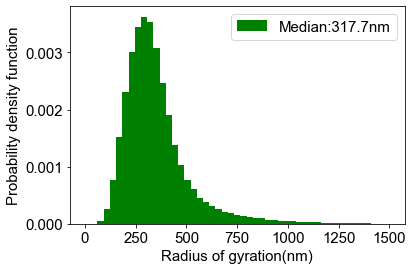

In [32]:
fig = plt.figure()
plt.hist(rgs,bins=np.linspace(0,1500,50),normed=True,color='green',label='Median:'+str(np.round(np.nanmedian(rgs),1))+'nm')
plt.xlabel('Radius of gyration(nm)')
plt.ylabel('Probability density function')
plt.legend()
print(np.median(rgs))
#folder_ = r'C:\Users\Bogdan\Dropbox\2020 Chromatin Imaging Manuscript\Revision\Bogdan_Figures\Figure1\base_images'
#fig.savefig(folder_+r'Fig1J.pdf')

C:\Users\Bogdan\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  import sys


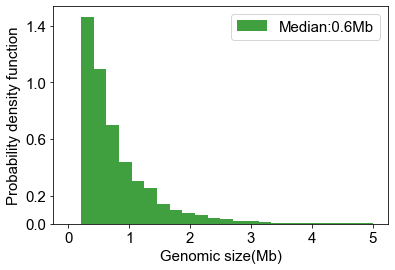

In [67]:
dom_starts_fs = data_rep1['domain_starts']

lens = np.array([len_ for dom_ in tqdm(dom_starts_fs) for len_ in np.diff(dom_[1:-1])])
lens_ = lens[lens>=5]*50*10**(-3)
fig = plt.figure()
bins = np.linspace(0,5000,25)*10**(-3)
plt.hist(lens_,bins=bins,color='green',normed=True,alpha=0.75,label='Median:'+str(np.round(np.nanmedian(lens_),1))+'Mb')
#plt.legend()
plt.ylabel('Probability density function')
plt.xlabel('Genomic size(Mb)')
plt.yticks([0,0.2,0.6,1,1.4])
plt.legend()
#folder_ = r'C:\Users\Bogdan\Dropbox\2020 Chromatin Imaging Manuscript\Revision\Bogdan_Figures\Figure1\base_images'
#fig.savefig(folder_+r'Fig1I.pdf')

### Check the repeat of Chr21

In [49]:
import functions.domain_tools.DomainAnalysis as da
import multiprocessing as mp

num_threads=32
domain_corr_cutoff = 0.75 
domain_dist_cutoff = 500 # nm

_domain_args = [(_hzxys[:,1:], 4, 1000, domain_corr_cutoff, domain_dist_cutoff) 
                     for _hzxys in data_rep2['dna_hzxys']]
_domain_time = time.time()

print(f"Multiprocessing call domain starts", end=' ')
with mp.Pool(num_threads) as domain_pool:
    domain_results = domain_pool.starmap(da.get_dom_starts_cor, _domain_args)
    domain_pool.close()
    domain_pool.join()
    domain_pool.terminate()
# save
data_rep2['domain_starts'] = [np.array(_r[-1]) for _r in domain_results]
data_rep2['params']['domain_corr_cutoff'] = domain_corr_cutoff
data_rep2['params']['domain_dist_cutoff'] = domain_dist_cutoff
    
print(f"in {time.time()-_domain_time:.3f}s.")

Multiprocessing call domain starts in 67.892s.


In [52]:
from tqdm import tqdm_notebook as tqdm
def rg_mean(zxy):
    """computes radius of gyration"""
    zxy_ = np.array(zxy)
    zxy_ = zxy_[~np.isnan(zxy_[:,0])]
    zxy_ = zxy_ - np.median(zxy_,0)
    return np.mean(np.linalg.norm(zxy_,axis=-1))
rgs_rep = []

zxys = data_rep2['dna_hzxys'][:,:,1:]
dom_starts_fs = data_rep2['domain_starts']
for pt_,doms_ in tqdm(zip(zxys,dom_starts_fs)):
    for i1,i2 in zip(doms_[1:-2],doms_[2:-1]):
        rgs_rep.append(rg_mean(pt_[i1:i2]))

C:\Users\Bogdan\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


317.69096502774136


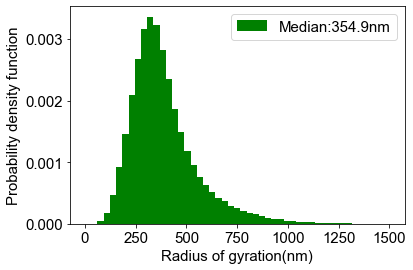

In [55]:
fig = plt.figure()
plt.hist(rgs_rep,bins=np.linspace(0,1500,50),normed=True,color='green',label='Median:'+str(np.round(np.nanmedian(rgs_rep),1))+'nm')
plt.xlabel('Radius of gyration(nm)')
plt.ylabel('Probability density function')
plt.legend()
print(np.median(rgs))
#folder_ = r'C:\Users\Bogdan\Dropbox\2020 Chromatin Imaging Manuscript\Revision\Bogdan_Figures\Figure1\base_images'
#fig.savefig(folder_+r'Fig1J.pdf')

C:\Users\Bogdan\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  
C:\Users\Bogdan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


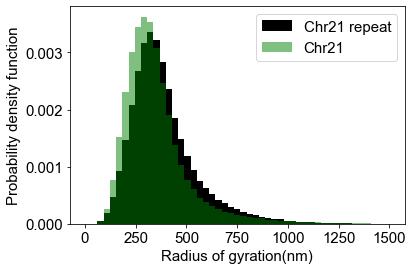

In [58]:
fig = plt.figure()
plt.hist(rgs_rep,bins=np.linspace(0,1500,50),normed=True,color='black',label='Chr21 repeat')# - median:'+str(int(np.nanmedian(rgs_rep))))
plt.hist(rgs,bins=np.linspace(0,1500,50),normed=True,color='green',alpha=0.5,label='Chr21')# - median:'+str(int(np.nanmedian(rgs))))

plt.xlabel('Radius of gyration(nm)')
plt.ylabel('Probability density function')
plt.legend()
#folder_ = r'C:\Users\Bogdan\Dropbox\2020 Chromatin Imaging Manuscript\Revision\Bogdan_Figures\Figure1\base_images'
#fig.savefig(folder_+r'Fig1J.pdf')

C:\Users\Bogdan\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  import sys


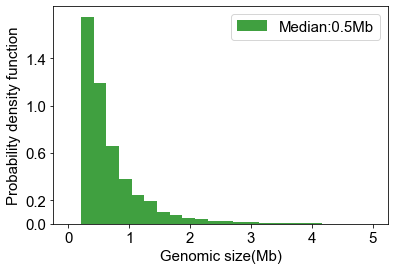

In [66]:
dom_starts_fs = data_rep2['domain_starts']

lens = np.array([len_ for dom_ in tqdm(dom_starts_fs) for len_ in np.diff(dom_[1:-1])])
lens_rep = lens[lens>=5]*50*10**(-3)
fig = plt.figure()
bins = np.linspace(0,5000,25)*10**(-3)
plt.hist(lens_rep,bins=bins,color='green',normed=True,alpha=0.75,label='Median:'+str(np.round(np.nanmedian(lens_),1))+'Mb')
#plt.legend()
plt.ylabel('Probability density function')
plt.xlabel('Genomic size(Mb)')
plt.yticks([0,0.2,0.6,1,1.4])
plt.legend()
#folder_ = r'C:\Users\Bogdan\Dropbox\2020 Chromatin Imaging Manuscript\Revision\Bogdan_Figures\Figure1\base_images'
#fig.savefig(folder_+r'Fig1I.pdf')

C:\Users\Bogdan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Bogdan\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


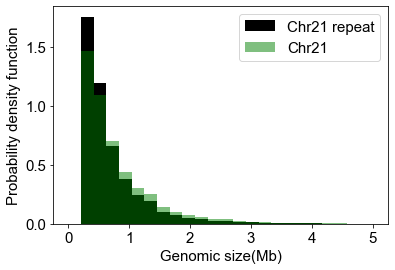

In [70]:
fig = plt.figure()
bins = np.linspace(0,5000,25)*10**(-3)
plt.hist(lens_rep,bins=bins,normed=True,color='black',label='Chr21 repeat')# - median:'+str(int(np.nanmedian(rgs_rep))))
plt.hist(lens_,bins=bins,normed=True,color='green',alpha=0.5,label='Chr21')# - median:'+str(int(np.nanmedian(rgs))))

plt.xlabel('Genomic size(Mb)')
plt.ylabel('Probability density function')
plt.legend()
#folder_ = r'C:\Users\Bogdan\Dropbox\2020 Chromatin Imaging Manuscript\Revision\Bogdan_Figures\Figure1\base_images'
#fig.savefig(folder_+r'Fig1J.pdf')

# Single-cell boundary probability, insulation and alignment with CTCF/TADs

In [83]:
dom_starts_fs = data_rep1['domain_starts']
zxys = data_rep1['dna_hzxys'][:,:,1:]
pts= zxys

### calculate contact map

In [85]:
cutoff = 500
num_contacts = np.zeros([len(zxys[0])]*2)
num_detected = np.zeros([len(zxys[0])]*2)
for zxy in tqdm(zxys):
    M = squareform(pdist(zxy))
    num_contacts+=M<cutoff
    num_detected+=M>=0 #this excludes nan's
contact_map = num_contacts/num_detected   

C:\Users\Bogdan\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  
C:\Users\Bogdan\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater_equal
  import sys


[Text(1, 0, '0.03300000000000001'),
 Text(1, 0, '0.0993322172549506'),
 Text(1, 0, '0.2989966480237789'),
 Text(1, 0, '0.9')]

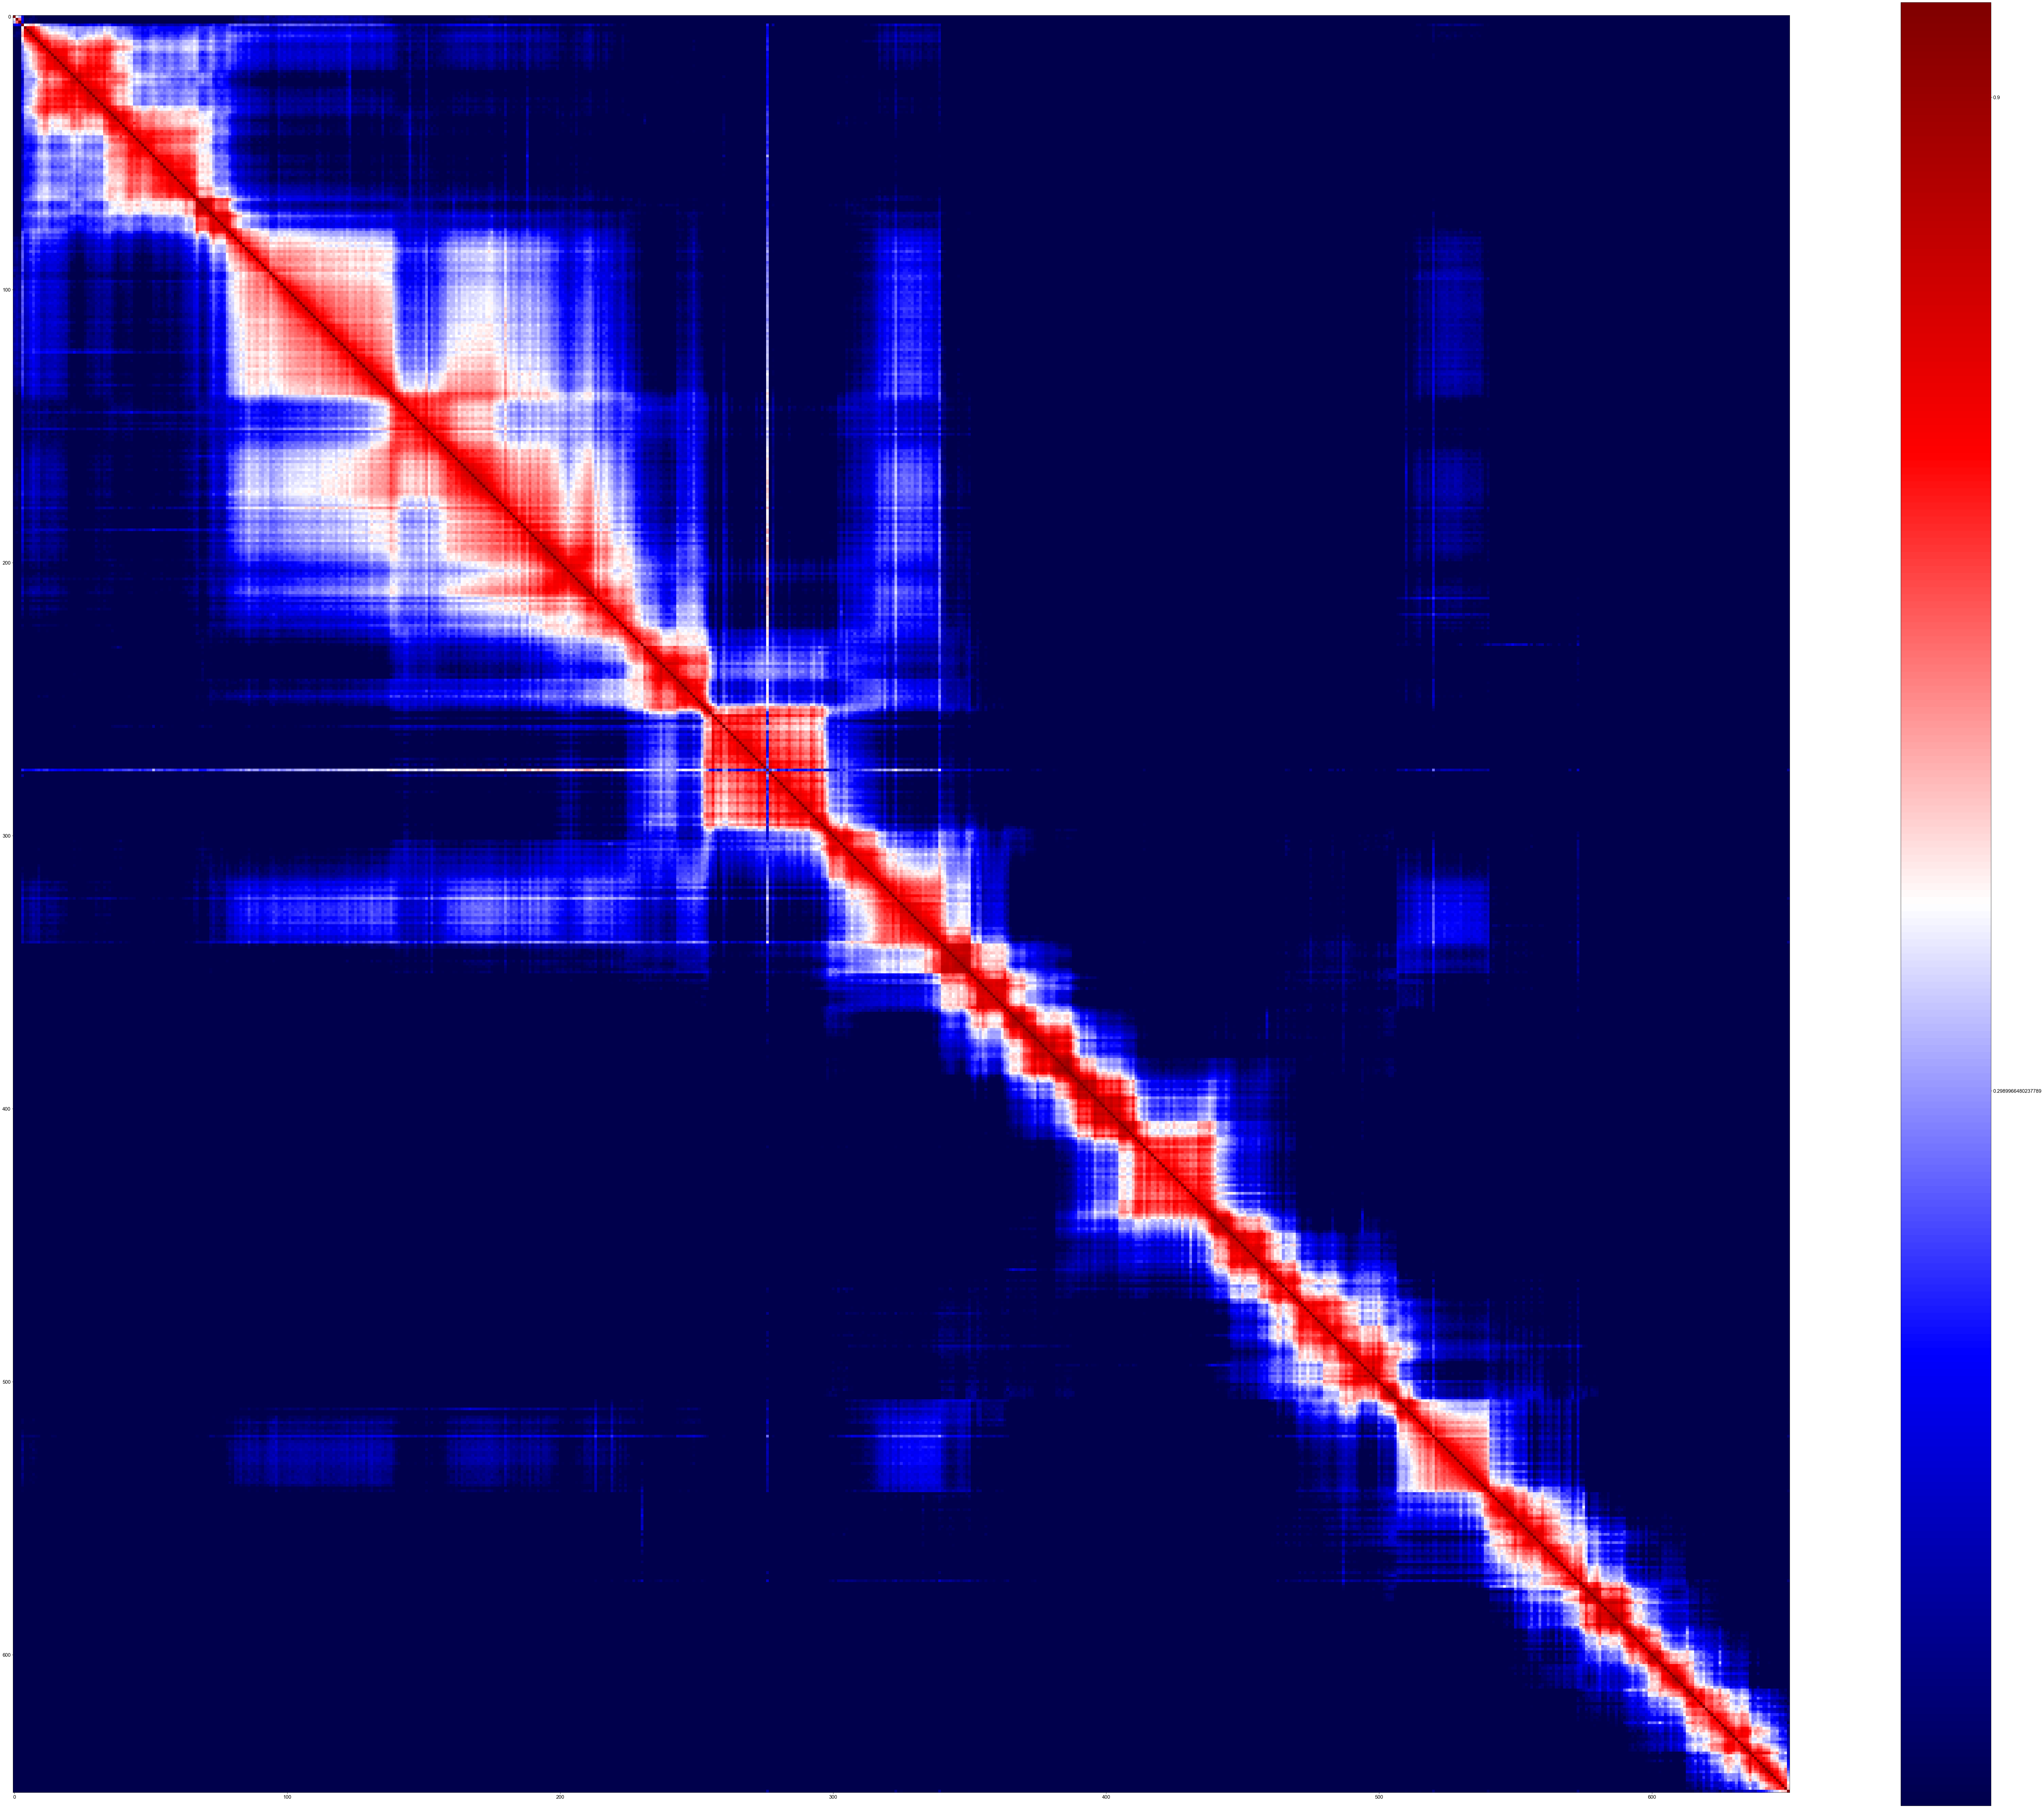

In [87]:
fig = plt.figure(figsize=(120,100))
cax = plt.imshow(np.log(contact_map),vmax=0,vmin=-2,cmap='seismic')
x_ = np.linspace(np.log(0.033),np.log(0.9),4)
cbar = plt.colorbar(ticks=x_)
cbar.ax.set_yticklabels(list(map(str,np.exp(x_))))  # vertically oriented colorbar
#folder_ = r'C:\Users\Bogdan\Dropbox\2020 Chromatin Imaging Manuscript\Revision\Bogdan_Figures\Figure1\base_images'
#fig.savefig(folder_+r'Fig1C_upper.pdf')
#fig.savefig(r'C:\Users\Bogdan\Dropbox\2020 Chromatin Imaging Manuscript\Revision\Bogdan_Figures\FigureS1\S1D.pdf')

### calculate boundary probability

In [88]:
dom_all = np.array([dom for doms in dom_starts_fs[::] for dom in doms[1:-1]])
unk_,cts_=np.unique(dom_all,return_counts=True)
cts = np.zeros(len(pts[0]))
cts[unk_]=cts_

### boundary probability for a zoom-in example

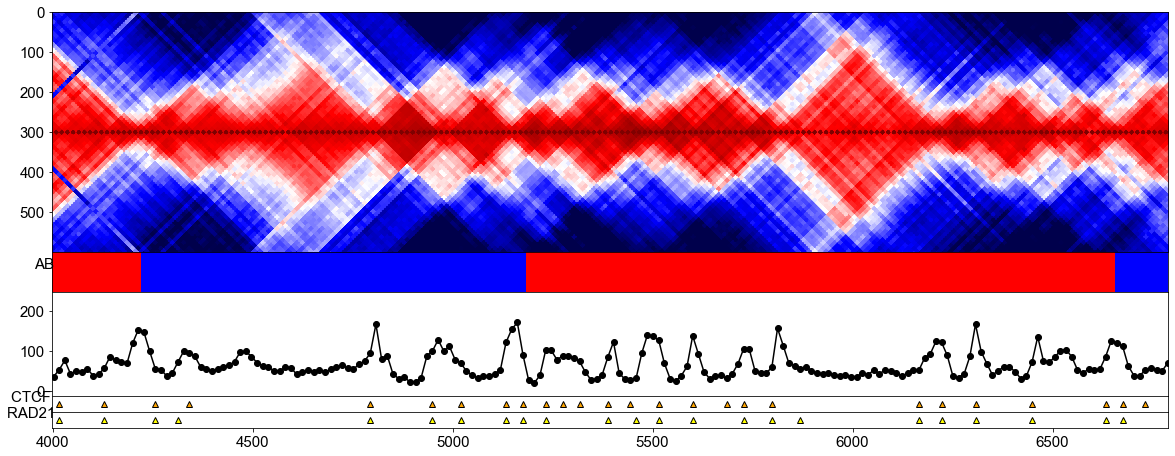

In [89]:
import matplotlib.pyplot as plt
import numpy as np
import pickle,os
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import pdist,cdist,squareform


####### You will need cv2. If you do not have it, run: pip install opencv-python
import cv2


from matplotlib import cm


def resize(im__,scale_percent = 100):
    width = int(im__.shape[1] * scale_percent / 100)
    height = int(im__.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized = cv2.resize(im__, dim, interpolation = cv2.INTER_NEAREST)
    return resized

def rotate_bound(image, angle):
    # grab the dimensions of the image and then determine the
    # center
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
 
    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
 
    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
 
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
 
    # perform the actual rotation and return the image
    return cv2.warpAffine(image, M, (nW, nH),cv2.INTER_NEAREST)


def interp1dnan(A):
    A_=np.array(A)
    ok = np.isnan(A)==False
    xp = ok.nonzero()[0]
    fp = A[ok]
    x  = np.isnan(A).nonzero()[0]
    A_[np.isnan(A)] = np.interp(x, xp, fp)
    return A_

def interpolate_chr(_chr):
    """linear interpolate chromosome coordinates"""
    _new_chr = np.array(_chr)
    for i in range(_new_chr.shape[-1]):
        _new_chr[:,i]=interp1dnan(_new_chr[:,i])
    return _new_chr
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib import cm
fig = plt.figure(figsize=(20,20))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 1),axes_pad=0.)


mat_ = np.log(contact_map)
pad=0
min_val,max_val = -2,None   # the minimum and maximum distance in nanometers. this sets the threshold of the image
if max_val is None: max_val = np.nanmax(mat_)
if min_val is None: min_val = np.nanmin(mat_)
#This colors the image
im_ = (np.clip(mat_,min_val,max_val)-min_val)/(max_val-min_val)
im__ = np.array(cm.seismic(im_)[:,:,:3]*255,dtype=np.uint8)

# resize image 10x to get good resolution
resc = 10############
resized = resize(im__,resc*100)

# Rotate 45 degs
resized = rotate_bound(resized,-45)
start = int(pad*np.sqrt(2)*resc)
center = int(resized.shape[1]/2)

#Clip it to the desired size
padup=30##### how much of the matrix to keep in the up direction
resized = resized[center-resc*padup:center+resc*padup]



#List of positions of CTCF and rad21 in chr21
#ctcf 
ctcf = [  9,  21,  33,  67,  73,  78, 139, 226, 231, 235, 242, 253, 256,
       273, 284, 292, 301, 307, 339, 350, 355, 363, 366, 370, 373, 376,
       381, 385, 390, 396, 402, 405, 410, 436, 440, 446, 456, 469, 472,
       476, 482, 485, 488, 492, 500, 505, 508, 512, 520, 540, 543, 550,
       554, 560, 565, 576, 580, 585, 589, 592, 595, 599, 602, 606, 615,
       619, 622, 625, 628, 633, 636, 639]
# rad21
rad21=[ 21,  33,  67,  73, 139, 226, 231, 236, 242, 256, 273, 284, 292,
       301, 305, 339, 350, 355, 363, 366, 370, 381, 386, 390, 396, 405,
       410, 415, 436, 440, 446, 456, 469, 472, 482, 485, 492, 500, 505,
       508, 512, 543, 550, 554, 560, 576, 581, 585, 589, 593, 596, 599,
       602, 615, 619, 622, 625, 628, 633, 636]
A = [255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 494, 495, 496, 497, 498, 499, 500, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650]
A_=np.zeros([len(cts),100])
A_[A,:]=1
A_ = A_[np.linspace(0,len(A_)-1,resized.shape[1]).astype(int)]

start = 0
min__ = 0
cts_perc = 1.*cts/len(pts)*100*resc
x_vals = (np.arange(len(cts_perc))-min__)*resc*np.sqrt(2)-start
### plot the tads as vertical gray line
#bds_avg_ = (np.array(bds_avg)-min__)*resc*np.sqrt(2)-start
#for ele in bds_avg_:
#    grid[2].plot([ele,ele],[0,np.max(cts_perc)],color='gray')


grid[1].imshow(A_.T,cmap='bwr')
grid[2].plot(x_vals,cts_perc,'ko-')
grid[0].imshow(resized)
grid[3].plot(x_vals[ctcf],[0]*len(ctcf),'^',color='orange',mec='k')
grid[4].plot(x_vals[rad21],[0]*len(rad21),'^',color='yellow',mec='k')
ypad=20
grid[3].set_ylim([-ypad,ypad])
grid[4].set_ylim([-ypad,ypad])
grid[3].set_yticks([])
grid[4].set_yticks([])
grid[1].set_yticks([])
grid[1].set_ylabel('AB  ',rotation='horizontal')
grid[3].set_ylabel('CTCF        ',rotation='horizontal')
grid[4].set_ylabel('RAD21        ',rotation='horizontal')
min_,max_ = (282.69965127943635, 480)
grid[0].set_xlim([min_*resc*np.sqrt(2),max_*resc*np.sqrt(2)])
plt.show()
#folder_ = r'C:\Users\Bogdan\Dropbox\2020 Chromatin Imaging Manuscript\Revision\Bogdan_Figures\Figure1\base_images'
#fig.savefig(folder_+r'Fig1C_lower.pdf')

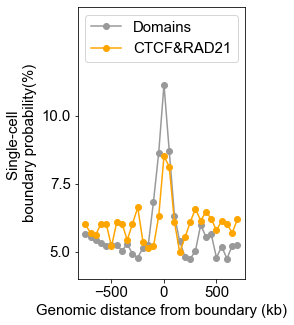

In [82]:
#List of positions of CTCF and rad21 in chr21
#ctcf 
ctcf = [  9,  21,  33,  67,  73,  78, 139, 226, 231, 235, 242, 253, 256,
       273, 284, 292, 301, 307, 339, 350, 355, 363, 366, 370, 373, 376,
       381, 385, 390, 396, 402, 405, 410, 436, 440, 446, 456, 469, 472,
       476, 482, 485, 488, 492, 500, 505, 508, 512, 520, 540, 543, 550,
       554, 560, 565, 576, 580, 585, 589, 592, 595, 599, 602, 606, 615,
       619, 622, 625, 628, 633, 636, 639]
# rad21
rad21=[ 21,  33,  67,  73, 139, 226, 231, 236, 242, 256, 273, 284, 292,
       301, 305, 339, 350, 355, 363, 366, 370, 381, 386, 390, 396, 405,
       410, 415, 436, 440, 446, 456, 469, 472, 482, 485, 492, 500, 505,
       508, 512, 543, 550, 554, 560, 576, 581, 585, 589, 593, 596, 599,
       602, 615, 619, 622, 625, 628, 633, 636]

A = [255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 494, 495, 496, 497, 498, 499, 500, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650]
A_ = np.zeros(len(zxys[0])+2)
A_[np.array(A)+1]=1
AB_bds = np.abs(np.diff(A_))
AB_bds = np.where(AB_bds)[0]
pts = zxys
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['font.size']=15
matplotlib.rcParams['font.family']='Arial'
fig = plt.figure(figsize=(3,5))
#from jun-han - 500nm
bds_avg_ = [20, 35, 52, 67, 80, 113, 139, 159, 179, 198, 213, 227, 254, 273, 298, 317, 340, 351, 365, 373, 388, 411, 439, 460, 471, 486, 507, 540, 550, 561, 575, 592, 604, 613, 627, 636, 644]
dmat = np.abs(np.array([[bd2-bd1 for bd1 in bds_avg_] for bd2 in np.arange(len(pts[0]))],dtype=int))
dmat = np.array([[bd2-bd1 for bd1 in bds_avg_] for bd2 in np.arange(len(pts[0]))],dtype=int)
range_ = range(-15,15)
yvec = np.array([np.median(cts[np.where(dmat==i)[0]]) for i in range_])
plt.plot(np.array(range_)*50,yvec/len(pts)*100,'o-',color=[0.6]*3,label='Domains')
dmat = np.abs(np.array([[bd2-bd1 for bd1 in AB_bds] for bd2 in np.arange(len(pts[0]))],dtype=int))
dmat = np.array([[bd2-bd1 for bd1 in AB_bds] for bd2 in np.arange(len(pts[0]))],dtype=int)
yvec = np.array([np.median(cts[np.where(dmat==i)[0]]) for i in range_])
#plt.plot(np.array(range_)*50,yvec/len(pts)*100,'ko-',label='A/B compartments')
ctcf_rad21 = np.intersect1d(rad21,ctcf)
dmat = np.array([[bd2-bd1 for bd1 in ctcf_rad21] for bd2 in np.arange(len(pts[0]))],dtype=int)
yvec = np.array([np.median(cts[np.where(dmat==i)[0]]) for i in range_])
plt.plot(np.array(range_)*50,yvec/len(pts)*100,'o-',color='orange',label='CTCF&RAD21')

plt.yticks([5,7.5,10])
plt.ylim([4,14])
plt.xlabel('Genomic distance from boundary (kb)')
plt.ylabel('Single-cell \nboundary probability(%)')
plt.legend()
#folder_ = r'C:\Users\Bogdan\Dropbox\2020 Chromatin Imaging Manuscript\Revision\Bogdan_Figures\Figure1\base_images'
#fig.savefig(folder_+r'Fig1D.pdf')

In [75]:
ichr=0
ins = []
A = [255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 494, 495, 496, 497, 498, 499, 500, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650]
A_ = np.zeros(len(zxys[0]))
A_[np.array(A)]=1
pur=[]
bdr_ins = []

dom_starts_fs = data_rep1['domain_starts']
zxys = data_rep1['dna_hzxys'][:,:,1:]
for dom_ in tqdm(dom_starts_fs):
    zxy_ = zxys[ichr]
    for idom in range(1,len(dom_)-3):
        a,b,c = dom_[idom],dom_[idom+1],dom_[idom+2]
        #a,b,c = dom_[idom+1]-5,dom_[idom+1],dom_[idom+1]+5
        zxy1 = zxy_[a:b]
        zxy2 = zxy_[b:c]
        
        med_in = np.nanmedian(np.concatenate([pdist(zxy1),pdist(zxy2)]))
        med_out = np.nanmedian(cdist(zxy1,zxy2))
        ins_ = med_out/med_in
        ins.append(ins_)
        pur.append(np.mean(A_[a:c]))
        bdr_ins.append(b)
    ichr+=1    
    
pur=np.array(pur)
bdr_ins=np.array(bdr_ins)
ins = np.array(ins)

C:\Users\Bogdan\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  if __name__ == '__main__':
C:\Users\Bogdan\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  # Remove the CWD from sys.path while we load stuff.


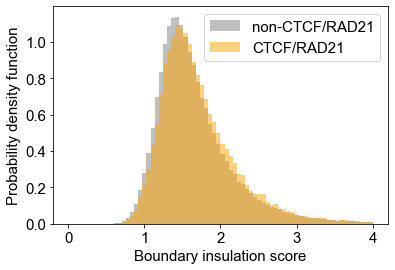

In [90]:
nonctcf = np.ones(len(zxys[0]))
nonctcf[ctcf_rad21]=0
nonctcf = np.nonzero(nonctcf)[0]

fig = plt.figure()#figsize=(10,7))
bins=np.linspace(0,4,75)
#plt.hist(ins[pur==1],alpha=0.5,normed=True,bins=bins,color='r',label = 'within A')
#plt.hist(ins[pur==0],alpha=0.5,normed=True,bins=bins,color='b',label = 'within B')
plt.hist(ins[np.in1d(bdr_ins,nonctcf)],alpha=0.5,normed=True,bins=bins,color='gray',label = 'non-CTCF/RAD21')
plt.hist(ins[np.in1d(bdr_ins,ctcf_rad21)],alpha=0.5,normed=True,bins=bins,color='orange',label = 'CTCF/RAD21')
plt.xlabel('Boundary insulation score')
plt.ylabel('Probability density function')
plt.legend()
#folder_ = r'C:\Users\Bogdan\Dropbox\2020 Chromatin Imaging Manuscript\Revision\Bogdan_Figures\Figure1\base_images'
#fig.savefig(folder_+r'Fig1K.pdf')

# Check repeat

In [93]:
dom_starts_fs = data_rep2['domain_starts']
zxys = data_rep2['dna_hzxys'][:,:,1:]
pts=zxys

In [94]:
cutoff = 500
num_contacts = np.zeros([len(zxys[0])]*2)
num_detected = np.zeros([len(zxys[0])]*2)
for zxy in tqdm(zxys):
    M = squareform(pdist(zxy))
    num_contacts+=M<cutoff
    num_detected+=M>=0 #this excludes nan's
contact_map = num_contacts/num_detected   

C:\Users\Bogdan\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  
C:\Users\Bogdan\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater_equal
  import sys


[Text(1, 0, '0.03300000000000001'),
 Text(1, 0, '0.0993322172549506'),
 Text(1, 0, '0.2989966480237789'),
 Text(1, 0, '0.9')]

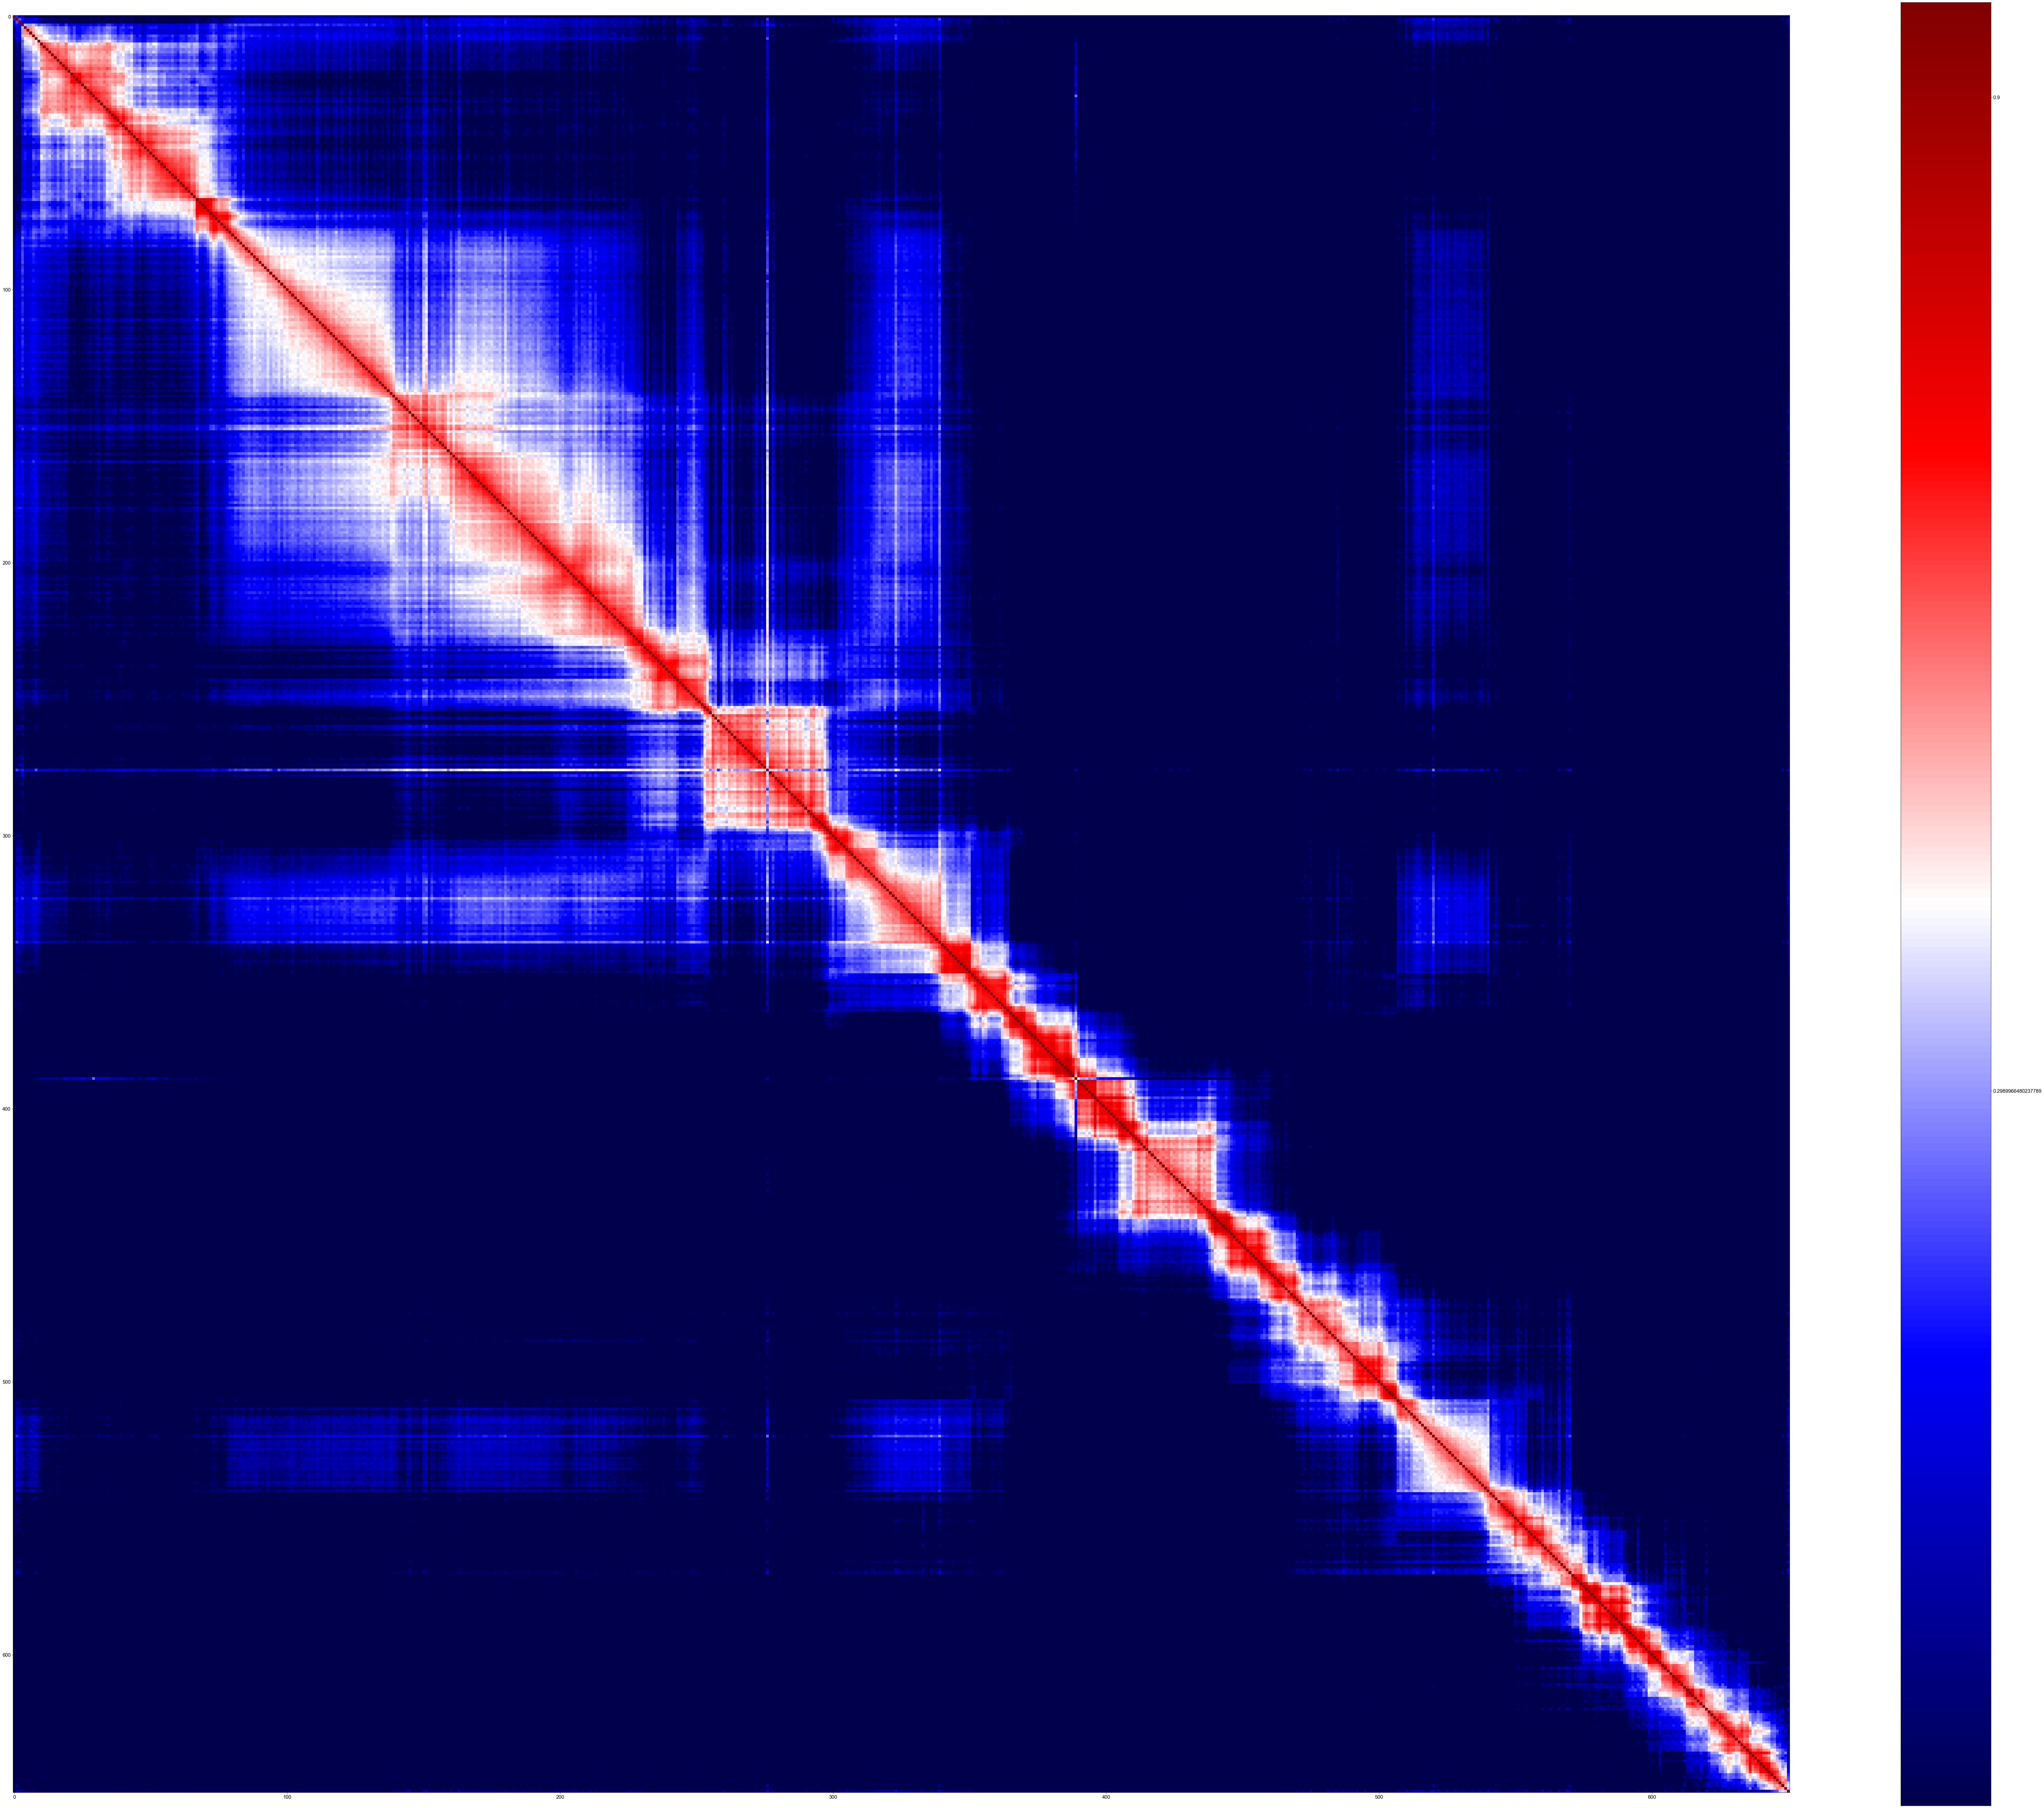

In [95]:
fig = plt.figure(figsize=(120,100))
cax = plt.imshow(np.log(contact_map),vmax=0,vmin=-2,cmap='seismic')
x_ = np.linspace(np.log(0.033),np.log(0.9),4)
cbar = plt.colorbar(ticks=x_)
cbar.ax.set_yticklabels(list(map(str,np.exp(x_))))  # vertically oriented colorbar
#folder_ = r'C:\Users\Bogdan\Dropbox\2020 Chromatin Imaging Manuscript\Revision\Bogdan_Figures\Figure1\base_images'
#fig.savefig(folder_+r'Fig1C_upper.pdf')
#fig.savefig(r'C:\Users\Bogdan\Dropbox\2020 Chromatin Imaging Manuscript\Revision\Bogdan_Figures\FigureS1\S1D.pdf')

### calculate boundary probability

In [96]:
dom_all = np.array([dom for doms in dom_starts_fs[::] for dom in doms[1:-1]])
unk_,cts_=np.unique(dom_all,return_counts=True)
cts = np.zeros(len(pts[0]))
cts[unk_]=cts_

### boundary probability for a zoom-in example

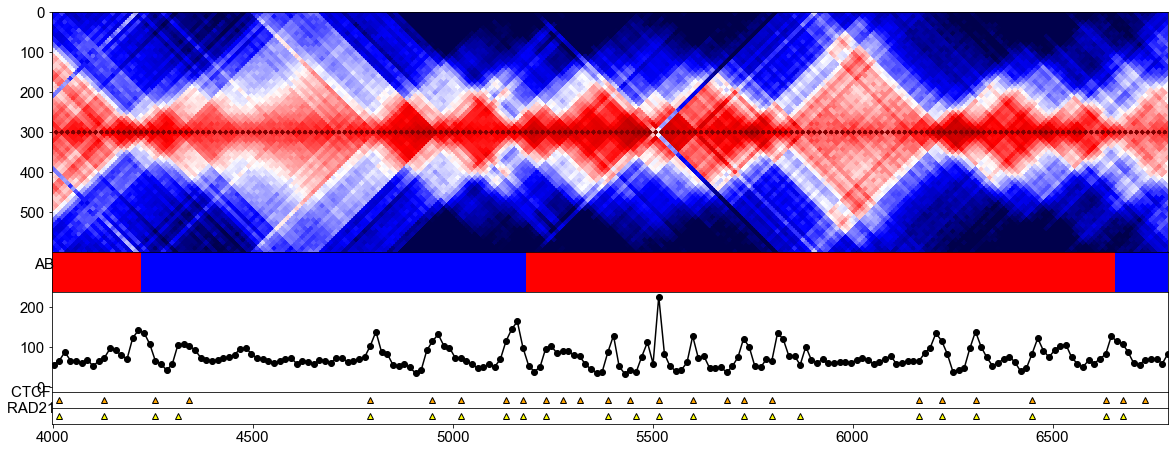

In [97]:
import matplotlib.pyplot as plt
import numpy as np
import pickle,os
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import pdist,cdist,squareform


####### You will need cv2. If you do not have it, run: pip install opencv-python
import cv2


from matplotlib import cm


def resize(im__,scale_percent = 100):
    width = int(im__.shape[1] * scale_percent / 100)
    height = int(im__.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized = cv2.resize(im__, dim, interpolation = cv2.INTER_NEAREST)
    return resized

def rotate_bound(image, angle):
    # grab the dimensions of the image and then determine the
    # center
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
 
    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
 
    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
 
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
 
    # perform the actual rotation and return the image
    return cv2.warpAffine(image, M, (nW, nH),cv2.INTER_NEAREST)


def interp1dnan(A):
    A_=np.array(A)
    ok = np.isnan(A)==False
    xp = ok.nonzero()[0]
    fp = A[ok]
    x  = np.isnan(A).nonzero()[0]
    A_[np.isnan(A)] = np.interp(x, xp, fp)
    return A_

def interpolate_chr(_chr):
    """linear interpolate chromosome coordinates"""
    _new_chr = np.array(_chr)
    for i in range(_new_chr.shape[-1]):
        _new_chr[:,i]=interp1dnan(_new_chr[:,i])
    return _new_chr
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib import cm
fig = plt.figure(figsize=(20,20))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 1),axes_pad=0.)


mat_ = np.log(contact_map)
pad=0
min_val,max_val = -2,None   # the minimum and maximum distance in nanometers. this sets the threshold of the image
if max_val is None: max_val = np.nanmax(mat_)
if min_val is None: min_val = np.nanmin(mat_)
#This colors the image
im_ = (np.clip(mat_,min_val,max_val)-min_val)/(max_val-min_val)
im__ = np.array(cm.seismic(im_)[:,:,:3]*255,dtype=np.uint8)

# resize image 10x to get good resolution
resc = 10############
resized = resize(im__,resc*100)

# Rotate 45 degs
resized = rotate_bound(resized,-45)
start = int(pad*np.sqrt(2)*resc)
center = int(resized.shape[1]/2)

#Clip it to the desired size
padup=30##### how much of the matrix to keep in the up direction
resized = resized[center-resc*padup:center+resc*padup]



#List of positions of CTCF and rad21 in chr21
#ctcf 
ctcf = [  9,  21,  33,  67,  73,  78, 139, 226, 231, 235, 242, 253, 256,
       273, 284, 292, 301, 307, 339, 350, 355, 363, 366, 370, 373, 376,
       381, 385, 390, 396, 402, 405, 410, 436, 440, 446, 456, 469, 472,
       476, 482, 485, 488, 492, 500, 505, 508, 512, 520, 540, 543, 550,
       554, 560, 565, 576, 580, 585, 589, 592, 595, 599, 602, 606, 615,
       619, 622, 625, 628, 633, 636, 639]
# rad21
rad21=[ 21,  33,  67,  73, 139, 226, 231, 236, 242, 256, 273, 284, 292,
       301, 305, 339, 350, 355, 363, 366, 370, 381, 386, 390, 396, 405,
       410, 415, 436, 440, 446, 456, 469, 472, 482, 485, 492, 500, 505,
       508, 512, 543, 550, 554, 560, 576, 581, 585, 589, 593, 596, 599,
       602, 615, 619, 622, 625, 628, 633, 636]
A = [255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 494, 495, 496, 497, 498, 499, 500, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650]
A_=np.zeros([len(cts),100])
A_[A,:]=1
A_ = A_[np.linspace(0,len(A_)-1,resized.shape[1]).astype(int)]

start = 0
min__ = 0
cts_perc = 1.*cts/len(pts)*100*resc
x_vals = (np.arange(len(cts_perc))-min__)*resc*np.sqrt(2)-start
### plot the tads as vertical gray line
#bds_avg_ = (np.array(bds_avg)-min__)*resc*np.sqrt(2)-start
#for ele in bds_avg_:
#    grid[2].plot([ele,ele],[0,np.max(cts_perc)],color='gray')


grid[1].imshow(A_.T,cmap='bwr')
grid[2].plot(x_vals,cts_perc,'ko-')
grid[0].imshow(resized)
grid[3].plot(x_vals[ctcf],[0]*len(ctcf),'^',color='orange',mec='k')
grid[4].plot(x_vals[rad21],[0]*len(rad21),'^',color='yellow',mec='k')
ypad=20
grid[3].set_ylim([-ypad,ypad])
grid[4].set_ylim([-ypad,ypad])
grid[3].set_yticks([])
grid[4].set_yticks([])
grid[1].set_yticks([])
grid[1].set_ylabel('AB  ',rotation='horizontal')
grid[3].set_ylabel('CTCF        ',rotation='horizontal')
grid[4].set_ylabel('RAD21        ',rotation='horizontal')
min_,max_ = (282.69965127943635, 480)
grid[0].set_xlim([min_*resc*np.sqrt(2),max_*resc*np.sqrt(2)])
plt.show()
#folder_ = r'C:\Users\Bogdan\Dropbox\2020 Chromatin Imaging Manuscript\Revision\Bogdan_Figures\Figure1\base_images'
#fig.savefig(folder_+r'Fig1C_lower.pdf')

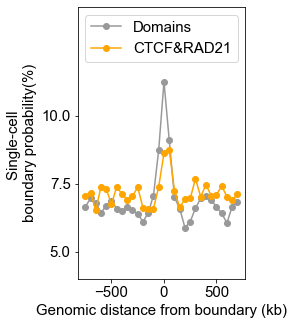

In [98]:
#List of positions of CTCF and rad21 in chr21
#ctcf 
ctcf = [  9,  21,  33,  67,  73,  78, 139, 226, 231, 235, 242, 253, 256,
       273, 284, 292, 301, 307, 339, 350, 355, 363, 366, 370, 373, 376,
       381, 385, 390, 396, 402, 405, 410, 436, 440, 446, 456, 469, 472,
       476, 482, 485, 488, 492, 500, 505, 508, 512, 520, 540, 543, 550,
       554, 560, 565, 576, 580, 585, 589, 592, 595, 599, 602, 606, 615,
       619, 622, 625, 628, 633, 636, 639]
# rad21
rad21=[ 21,  33,  67,  73, 139, 226, 231, 236, 242, 256, 273, 284, 292,
       301, 305, 339, 350, 355, 363, 366, 370, 381, 386, 390, 396, 405,
       410, 415, 436, 440, 446, 456, 469, 472, 482, 485, 492, 500, 505,
       508, 512, 543, 550, 554, 560, 576, 581, 585, 589, 593, 596, 599,
       602, 615, 619, 622, 625, 628, 633, 636]

A = [255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 494, 495, 496, 497, 498, 499, 500, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650]
A_ = np.zeros(len(zxys[0])+2)
A_[np.array(A)+1]=1
AB_bds = np.abs(np.diff(A_))
AB_bds = np.where(AB_bds)[0]
pts = zxys
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['font.size']=15
matplotlib.rcParams['font.family']='Arial'
fig = plt.figure(figsize=(3,5))
#from jun-han - 500nm
bds_avg_ = [20, 35, 52, 67, 80, 113, 139, 159, 179, 198, 213, 227, 254, 273, 298, 317, 340, 351, 365, 373, 388, 411, 439, 460, 471, 486, 507, 540, 550, 561, 575, 592, 604, 613, 627, 636, 644]
dmat = np.abs(np.array([[bd2-bd1 for bd1 in bds_avg_] for bd2 in np.arange(len(pts[0]))],dtype=int))
dmat = np.array([[bd2-bd1 for bd1 in bds_avg_] for bd2 in np.arange(len(pts[0]))],dtype=int)
range_ = range(-15,15)
yvec = np.array([np.median(cts[np.where(dmat==i)[0]]) for i in range_])
plt.plot(np.array(range_)*50,yvec/len(pts)*100,'o-',color=[0.6]*3,label='Domains')
dmat = np.abs(np.array([[bd2-bd1 for bd1 in AB_bds] for bd2 in np.arange(len(pts[0]))],dtype=int))
dmat = np.array([[bd2-bd1 for bd1 in AB_bds] for bd2 in np.arange(len(pts[0]))],dtype=int)
yvec = np.array([np.median(cts[np.where(dmat==i)[0]]) for i in range_])
#plt.plot(np.array(range_)*50,yvec/len(pts)*100,'ko-',label='A/B compartments')
ctcf_rad21 = np.intersect1d(rad21,ctcf)
dmat = np.array([[bd2-bd1 for bd1 in ctcf_rad21] for bd2 in np.arange(len(pts[0]))],dtype=int)
yvec = np.array([np.median(cts[np.where(dmat==i)[0]]) for i in range_])
plt.plot(np.array(range_)*50,yvec/len(pts)*100,'o-',color='orange',label='CTCF&RAD21')

plt.yticks([5,7.5,10])
plt.ylim([4,14])
plt.xlabel('Genomic distance from boundary (kb)')
plt.ylabel('Single-cell \nboundary probability(%)')
plt.legend()
#folder_ = r'C:\Users\Bogdan\Dropbox\2020 Chromatin Imaging Manuscript\Revision\Bogdan_Figures\Figure1\base_images'
#fig.savefig(folder_+r'Fig1D.pdf')

In [101]:
ichr=0
ins = []
A = [255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 494, 495, 496, 497, 498, 499, 500, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650]
A_ = np.zeros(len(zxys[0]))
A_[np.array(A)]=1
pur=[]
bdr_ins = []

for dom_ in tqdm(dom_starts_fs):
    zxy_ = zxys[ichr]
    for idom in range(1,len(dom_)-3):
        a,b,c = dom_[idom],dom_[idom+1],dom_[idom+2]
        #a,b,c = dom_[idom+1]-5,dom_[idom+1],dom_[idom+1]+5
        zxy1 = zxy_[a:b]
        zxy2 = zxy_[b:c]
        
        med_in = np.nanmedian(np.concatenate([pdist(zxy1),pdist(zxy2)]))
        med_out = np.nanmedian(cdist(zxy1,zxy2))
        ins_ = med_out/med_in
        ins.append(ins_)
        pur.append(np.mean(A_[a:c]))
        bdr_ins.append(b)
    ichr+=1    
    
pur=np.array(pur)
bdr_ins=np.array(bdr_ins)
ins = np.array(ins)

C:\Users\Bogdan\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  if __name__ == '__main__':
C:\Users\Bogdan\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  # Remove the CWD from sys.path while we load stuff.


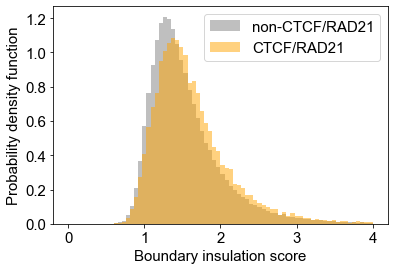

In [102]:
nonctcf = np.ones(len(zxys[0]))
nonctcf[ctcf_rad21]=0
nonctcf = np.nonzero(nonctcf)[0]

fig = plt.figure()#figsize=(10,7))
bins=np.linspace(0,4,75)
#plt.hist(ins[pur==1],alpha=0.5,normed=True,bins=bins,color='r',label = 'within A')
#plt.hist(ins[pur==0],alpha=0.5,normed=True,bins=bins,color='b',label = 'within B')
plt.hist(ins[np.in1d(bdr_ins,nonctcf)],alpha=0.5,normed=True,bins=bins,color='gray',label = 'non-CTCF/RAD21')
plt.hist(ins[np.in1d(bdr_ins,ctcf_rad21)],alpha=0.5,normed=True,bins=bins,color='orange',label = 'CTCF/RAD21')
plt.xlabel('Boundary insulation score')
plt.ylabel('Probability density function')
plt.legend()
#folder_ = r'C:\Users\Bogdan\Dropbox\2020 Chromatin Imaging Manuscript\Revision\Bogdan_Figures\Figure1\base_images'
#fig.savefig(folder_+r'Fig1K.pdf')

# CTCF end-end distance and radii of gyration of CTCF bound domains

### check repeat

In [103]:
dom_starts_fs = data_rep2['domain_starts']
zxys = data_rep2['dna_hzxys'][:,:,1:]
pts=zxys

In [104]:
from tqdm import tqdm_notebook as tqdm
dic_ctcf = {}
dic_nonctcf = {}

def rg_med(zxy):
    """computes radius of gyration"""
    zxy_ = np.array(zxy)
    zxy_ = zxy_[~np.isnan(zxy_[:,0])]
    zxy_ = zxy_ - np.median(zxy_,0)
    return np.mean(np.linalg.norm(zxy_,axis=-1))

def inD(zxy): 
    """computest mean interdistance"""
    return np.nanmean(pdist(zxy))

dic_rgctcf = {}
dic_rgnonctcf = {}

dic_inDctcf = {}
dic_inDnonctcf = {}

dic_withinDctcf = {}
dic_withinDnonctcf = {}
###################### This does not save each ctcf pair in its own key but already groups by genomic distance
ctcf_or_rad21 = np.union1d(ctcf,rad21)
for ichr in tqdm(range(len(zxys))):
    doms=dom_starts_fs[ichr][1:-1]
    zxy = zxys[ichr]
    for i in range(len(doms)-1):
        e1,e2 = doms[i],doms[i+1]-1
        dist_ = np.linalg.norm(zxy[e1]-zxy[e2])
        gen_dist = e2-e1
        rg_ = rg_med(zxy[e1:e2])
        inD_ = inD(zxy[e1:e2])
        if (e1 in ctcf_or_rad21) and (e2 in ctcf_or_rad21):
            dic_ctcf[gen_dist]=dic_ctcf.get(gen_dist,[])+[dist_]
            dic_rgctcf[gen_dist]=dic_rgctcf.get(gen_dist,[])+[rg_]
            dic_inDctcf[gen_dist]=dic_inDctcf.get(gen_dist,[])+[inD_]
        if not np.any(np.in1d([e1,e1+1,e1-1,e2,e2+1,e2-1],ctcf_or_rad21)):
        #if not np.any(np.in1d([e1,e2],ctcf_or_rad21)):
            dic_nonctcf[gen_dist]=dic_nonctcf.get(gen_dist,[])+[dist_]
            dic_rgnonctcf[gen_dist]=dic_rgnonctcf.get(gen_dist,[])+[rg_]

        e1p = np.random.randint(e1+1,e2-1)
        e2p = np.random.randint(e1p,e2-1)
        if not np.any(np.in1d([e1p,e1p+1,e1p-1,e2p,e2p+1,e2p-1],ctcf_or_rad21)):
            gen_dist__ = abs(e1p-e2p)
            dist__ = np.linalg.norm(zxy[e1p]-zxy[e2p])
            dic_withinDnonctcf[gen_dist__]=dic_withinDnonctcf.get(gen_dist__,[])+[dist__]
        for e1p in range(e1+1,e2-1):
            for e2p in range(e1p,e2-1):
                if (e1p in ctcf_or_rad21) and (e2p in ctcf_or_rad21):
                    gen_dist__ = abs(e1p-e2p)
                    dist__ = np.linalg.norm(zxy[e1p]-zxy[e2p])
                    dic_withinDctcf[gen_dist__]=dic_withinDctcf.get(gen_dist__,[])+[dist__]


In [106]:
pickle.dump([dic_ctcf,dic_nonctcf,dic_rgctcf,dic_rgnonctcf,dic_inDctcf,dic_inDnonctcf,dic_withinDctcf,dic_withinDnonctcf],
           open(r'C:\Users\Bogdan\Dropbox\Chromosome21_online\rg_and_edge-edge_distance_v2_repeat','wb'))

In [107]:
gen_dists = np.sort(list(dic_ctcf.keys()))
gen_dists = gen_dists[gen_dists<=28]
gen_dists = gen_dists[gen_dists>=4]
print([len(dic_nonctcf.get(gn,[])) for gn in gen_dists])

[7581, 7965, 7433, 6196, 5486, 4646, 4032, 3419, 2956, 2347, 1997, 1876, 1618, 1437, 1291, 1115, 962, 896, 804, 642, 612, 589, 567, 512, 450]


In [108]:
def boostrap_err2(x_,y_,func,N=1000,perc_min=5,perc_max=95):
    elems = []
    for istrap in range(N):
        x__ = np.random.choice(x_,[len(x_)])
        y__ = np.random.choice(y_,[len(y_)])
        elems.append(func(x__,y__))
    return (np.nanpercentile(elems,perc_min),np.nanpercentile(elems,perc_max))

gen_dists = np.sort(list(dic_ctcf.keys()))
gen_dists = gen_dists[gen_dists<=28]
gen_dists = gen_dists[gen_dists>=4]
def func(x,y): return np.nanmedian(x)/np.nanmedian(y)
xelems = gen_dists*50
meds_ctcf = [func(dic_ctcf.get(gn,[]),dic_withinDctcf.get(gn,[])) for gn in gen_dists]
errs_ctcf = np.abs(np.array([boostrap_err2(dic_ctcf.get(gn,[]),dic_withinDctcf.get(gn,[]),func) 
                             for gn in tqdm(gen_dists)]).T-meds_ctcf)
xelems = gen_dists*50
meds_non = [func(dic_nonctcf.get(gn,[]),dic_withinDnonctcf.get(gn,[])) for gn in gen_dists]
errs_non = np.abs(np.array([boostrap_err2(dic_nonctcf.get(gn,[]),dic_withinDnonctcf.get(gn,[]),func) 
                             for gn in tqdm(gen_dists)]).T-meds_non)

Text(0.5, 0, 'Genomic distance (kb)')

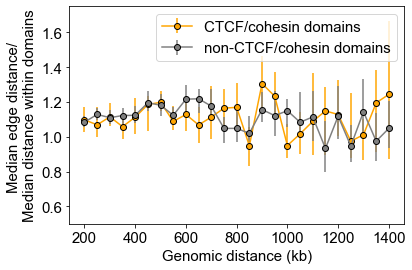

In [109]:
fig = plt.figure()
xelems = gen_dists*50
plt.errorbar(xelems,meds_ctcf,
             yerr=errs_ctcf,
             color='orange',mec='k',label='CTCF/cohesin domains',marker='o')

plt.errorbar(xelems,meds_non,
             yerr=errs_non,
             color='gray',mec='k',label='non-CTCF/cohesin domains',marker='o')
plt.legend()
plt.ylim([0.5,1.75])
plt.ylabel('Median edge distance/ \nMedian distance within domains')
plt.xlabel('Genomic distance (kb)')
#folder_ = r'C:\Users\Bogdan\Dropbox\2020 Chromatin Imaging Manuscript\Revision\FinalFigures\Figure 1\subpanels'
#fig.savefig(folder_+os.sep+r'Fig1L_new.pdf')

In [110]:
### Radius of gyration
def boostrap_err(x_,func,N=1000,perc_min=5,perc_max=95):
    elems = []
    for istrap in range(N):
        elems.append(func(np.random.choice(x_,[len(x_)])))
    return (np.nanpercentile(elems,perc_min),np.nanpercentile(elems,perc_max))

gen_dists = np.sort(list(dic_rgctcf.keys()))
gen_dists = gen_dists[gen_dists<=28]
gen_dists = gen_dists[gen_dists>=4]


func = np.nanmedian

xelems = gen_dists*50
meds_ctcf_rg = [func(dic_rgctcf[gn]) for gn in gen_dists]
errs_ctcf_rg = np.abs(np.array([boostrap_err(dic_rgctcf[gn],func) for gn in gen_dists]).T-meds_ctcf_rg)
xelems = gen_dists*50
meds_non_rg = [func(dic_rgnonctcf[gn]) for gn in gen_dists]
errs_non_rg = np.abs(np.array([boostrap_err(dic_rgnonctcf[gn],func) for gn in gen_dists]).T-meds_non_rg)

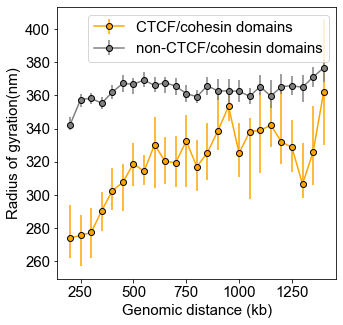

In [111]:
fig = plt.figure(figsize=(5,5))#figsize=(8,3))

plt.errorbar(xelems,meds_ctcf_rg,
             yerr=errs_ctcf_rg,
             color='orange',mec='k',label='CTCF/cohesin domains',marker='o')

plt.errorbar(xelems,meds_non_rg,
             yerr=errs_non_rg,
             color='gray',mec='k',label='non-CTCF/cohesin domains',marker='o')
plt.ylabel('Radius of gyration(nm)')
plt.xlabel('Genomic distance (kb)')
plt.legend()
#folder = r'C:\Users\Bogdan\Dropbox\2020 Chromatin Imaging Manuscript\Revision\FinalFigures\Figure S1\Sub-panels-newAnalysis'
#fig.savefig(folder+os.sep+'rg_ctcf_rgular.pdf')

### Radius of gyration vs genomic distance

In [117]:
dom_starts_fs = data_rep1['domain_starts']
zxys = data_rep1['dna_hzxys'][:,:,1:]
pts=zxys

In [118]:
def rg_med(zxy):
    """computes radius of gyration"""
    zxy_ = np.array(zxy)
    zxy_ = zxy_[~np.isnan(zxy_[:,0])]
    zxy_ = zxy_ - np.median(zxy_,0)
    return np.mean(np.linalg.norm(zxy_,axis=-1))

dic_rg = {}
for ichr in tqdm(range(len(pts))):
    doms=dom_starts_fs[ichr][1:-1]
    zxy = pts[ichr]
    for i in range(len(doms)-1):
        e1,e2 = doms[i],doms[i+1]-1
        start = e1
        end=e2#-1
        rg_ = rg_med(zxy[start:end])
        key = end-start
        dic_rg[key] = dic_rg.get(key,[])+[rg_]

Text(0.5, 0, 'Genomic size of single-cell domains (Mb)')

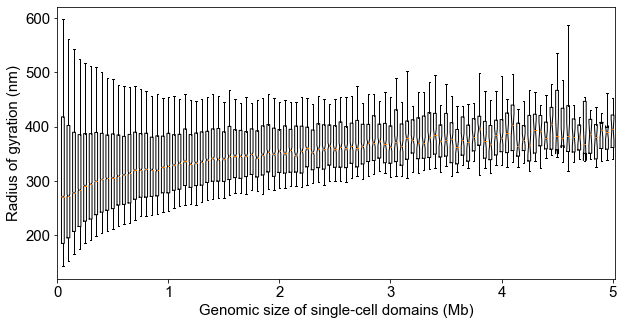

In [122]:
fig = plt.figure(figsize=(10,5))
keys = np.sort(list(dic_rg.keys()))
keys = keys[keys>=5]
plt.boxplot([dic_rg[gn] for gn in keys][:100], notch=True, showfliers=False,whis = [10, 90]);
xlab = np.arange(6)
plt.xticks(xlab*1000/50,xlab);
plt.ylabel('Radius of gyration (nm)')
plt.xlabel('Genomic size of single-cell domains (Mb)')
#save_folder = r'C:\Users\Bogdan\Dropbox\2020 Chromatin Imaging Manuscript\Revision\Bogdan_Figures\base_images\TAD_sizes'
#fig.savefig(save_folder+os.sep+'domain_Rgs_gensize_v2.pdf')

### check repeat

In [ ]:
dom_starts_fs = data_rep2['domain_starts']
zxys = data_rep2['dna_hzxys'][:,:,1:]
pts=zxys

In [112]:
def rg_med(zxy):
    """computes radius of gyration"""
    zxy_ = np.array(zxy)
    zxy_ = zxy_[~np.isnan(zxy_[:,0])]
    zxy_ = zxy_ - np.median(zxy_,0)
    return np.mean(np.linalg.norm(zxy_,axis=-1))

dic_rg = {}
for ichr in tqdm(range(len(pts))):
    doms=dom_starts_fs[ichr][1:-1]
    zxy = pts[ichr]
    for i in range(len(doms)-1):
        e1,e2 = doms[i],doms[i+1]-1
        start = e1
        end=e2#-1
        rg_ = rg_med(zxy[start:end])
        key = end-start
        dic_rg[key] = dic_rg.get(key,[])+[rg_]

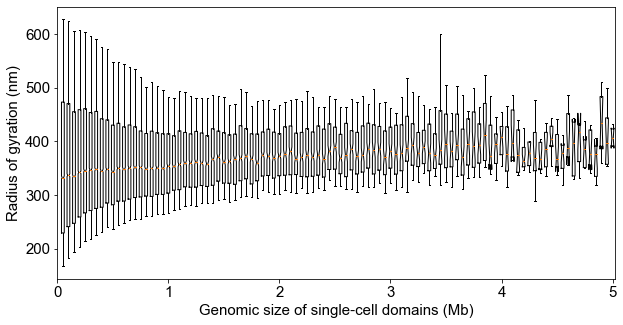

In [116]:
fig = plt.figure(figsize=(10,5))
keys = np.sort(list(dic_rg.keys()))
keys = keys[keys>=5]
plt.boxplot([dic_rg[gn] for gn in keys][:100], notch=True, showfliers=False,whis = [10, 90]);
xlab = np.arange(6)
plt.xticks(xlab*1000/50,xlab);
plt.ylabel('Radius of gyration (nm)')
plt.xlabel('Genomic size of single-cell domains (Mb)')
#save_folder = r'C:\Users\Bogdan\Dropbox\2020 Chromatin Imaging Manuscript\Revision\Bogdan_Figures\base_images\TAD_sizes'
#fig.savefig(save_folder+os.sep+'domain_Rgs_gensize_v2.pdf')